In [1]:
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt
from utils import *
from data_handling import *

42


In [2]:
fomc_calendar = pd.read_parquet('data/FOMC/fomc_calendar.parquet').set_index('datetime')

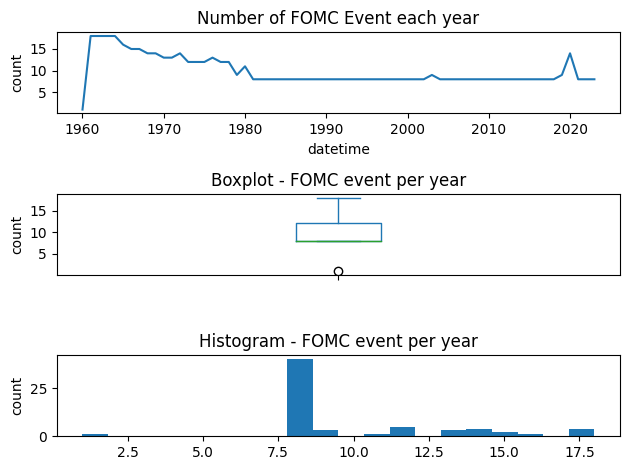

In [3]:
import matplotlib.pyplot as plt
count_year =fomc_calendar.groupby(fomc_calendar.index.year).size()
fig,axes = plt.subplots(nrows=3,ncols =1)
count_year.plot(ax = axes[0])
axes[0].set_title('Number of FOMC Event each year')
axes[0].set_ylabel('count')

count_year.plot(kind = 'box',ax=axes[1])
axes[1].set_title('Boxplot - FOMC event per year')
axes[1].set_ylabel('count')

count_year.plot(kind = 'hist',ax=axes[2],bins = 20)
axes[2].set_title('Histogram - FOMC event per year')
axes[2].set_ylabel('count')
fig.tight_layout()
fig.savefig("plots/FOMC_count.png")

## Regressors - Macroeconomic indicators


In [4]:
indicator,Y = reindex_X("JPY",max_nan_pct =20)

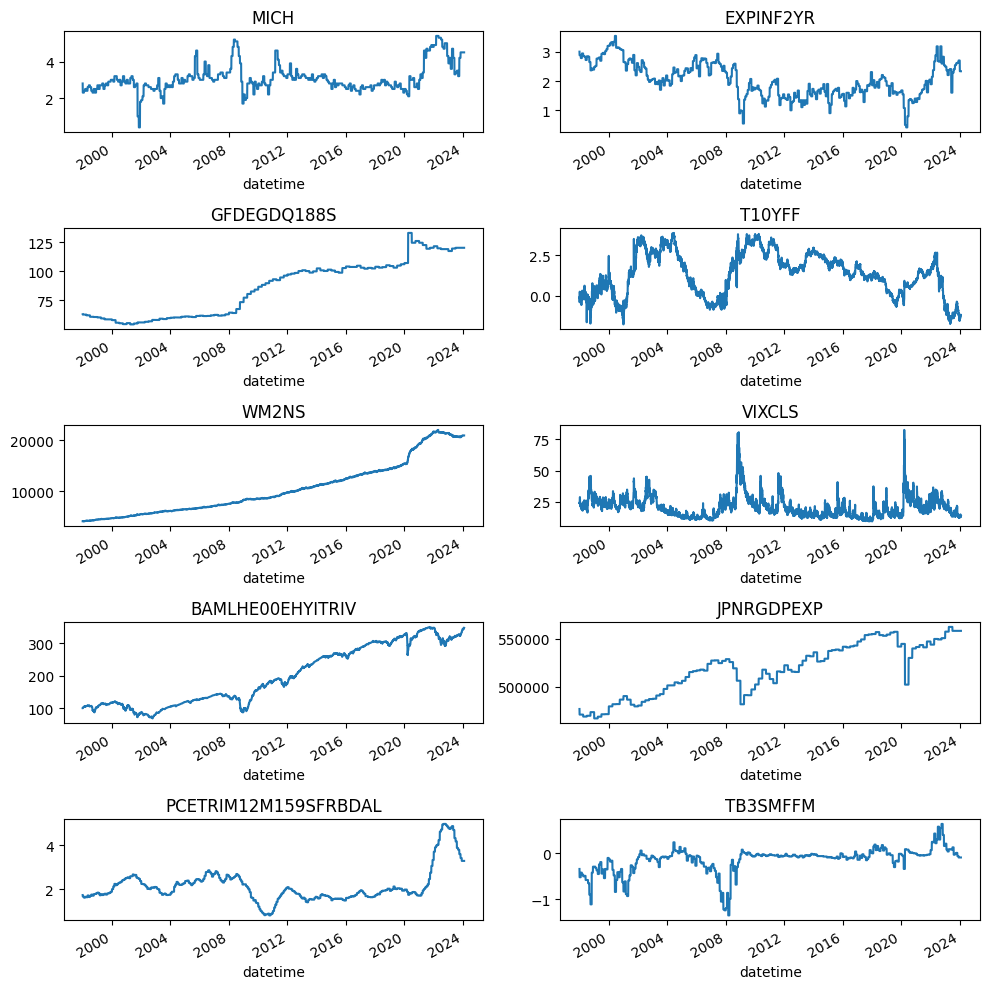

In [5]:
random_indicators = random.sample(indicator.columns.tolist(),10)
fig,axes = plt.subplots(nrows = 5, ncols = 2,figsize = (10,10))
rows = 5
cols = 2
for i,ax in enumerate(axes.flatten()):
    ts = random_indicators[i]
    indicator[ts].dropna().plot(ax = ax)
    ax.set_title(ts)

fig.tight_layout()
fig.savefig('plots/macro_indicators_before_zscore.png')

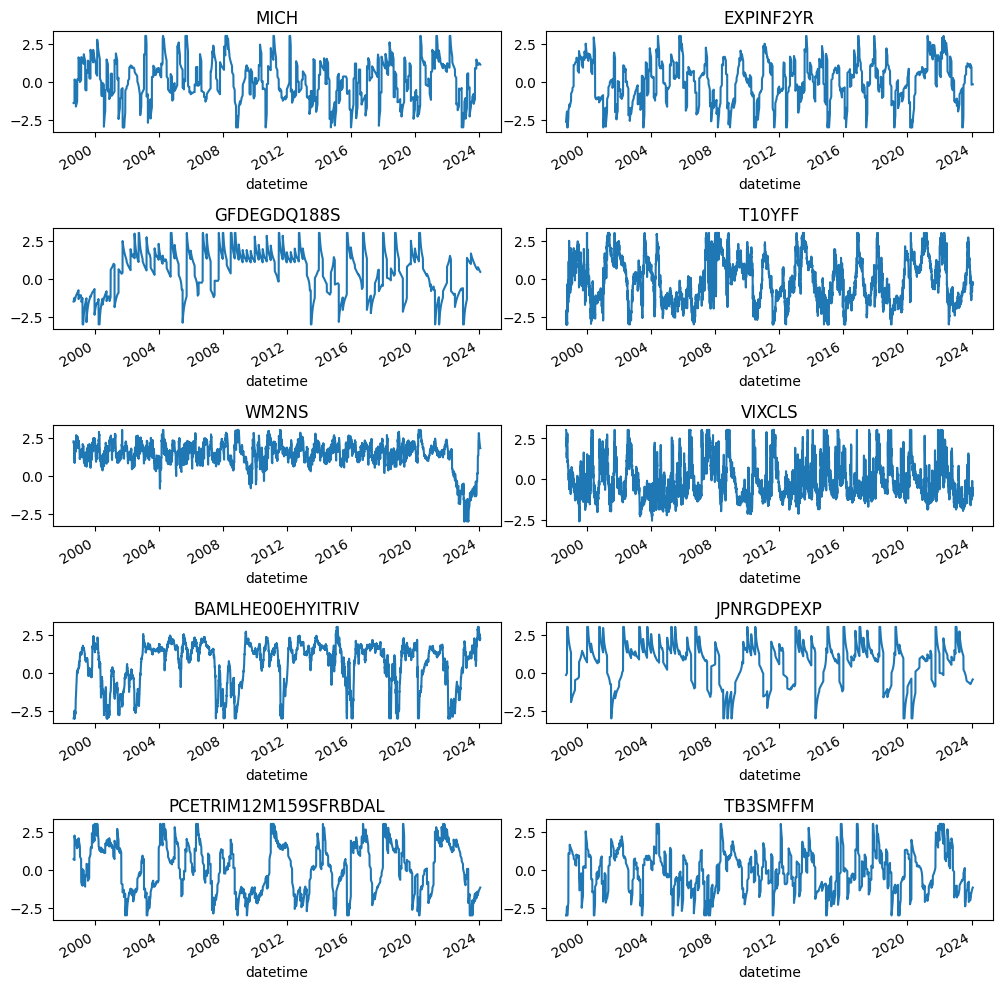

In [6]:
rolling_window = 252
zscore_indicator = zscore(indicator[random_indicators],rolling_window).clip(-3,3).dropna()
fig,axes = plt.subplots(nrows = 5, ncols = 2,figsize = (10,10))
rows = 5
cols = 2

for i,ax in enumerate(axes.flatten()):
    ts = random_indicators[i]
    zscore_indicator[ts].dropna().plot(ax = ax)
    ax.set_title(ts)

fig.tight_layout()
fig.savefig('plots/macro_indicators_after_zscore.png')

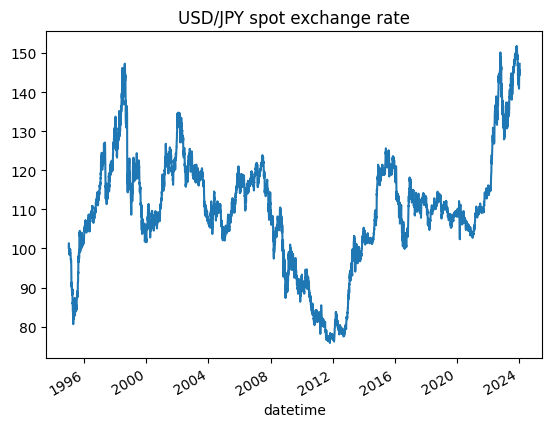

In [7]:
Y.dropna().plot(legend = False)
plt.legend = False
plt.title('USD/JPY spot exchange rate')
plt.savefig('plots/USD_JPY_spot_rate.png')

### Computing target feature : cumulative return of USD/JPY for the window -5 / + 5 businness days around the event FOMC

In [8]:
fed_meetings = get_fomc_calendar()
Y_fomc = create_Y(Y,fed_meetings,"all")
business_days = pd.date_range(start=Y_fomc.index.min(), end=Y_fomc.index.max(), freq='B')
reindexed_Y_fomc = Y_fomc.reindex(business_days)

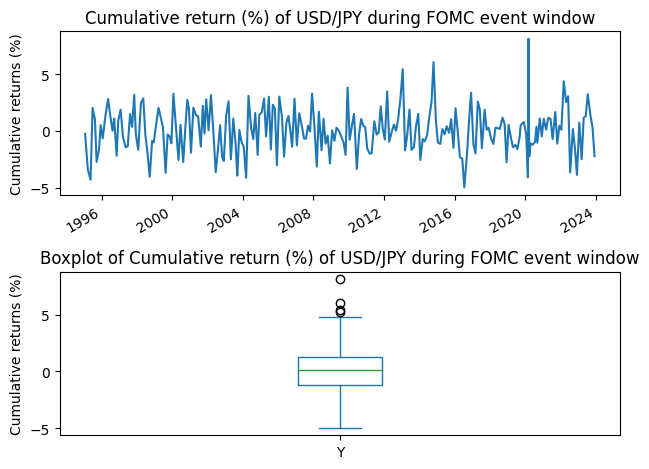

In [9]:
fig,axes = plt.subplots(nrows = 2,ncols = 1)
Y_fomc.ffill(limit = 10).plot(ax = axes[0], legend=False)
axes[0].set_title('Cumulative return (%) of USD/JPY during FOMC event window')
axes[0].set_ylabel('Cumulative returns (%)')
Y_fomc.plot(kind = 'box',ax = axes[1], legend=False)
axes[1].set_title('Boxplot of Cumulative return (%) of USD/JPY during FOMC event window')
axes[1].set_ylabel('Cumulative returns (%)')
fig.tight_layout()

fig.savefig('plots/USD_JPY_spot_rate_during_fomc.png')

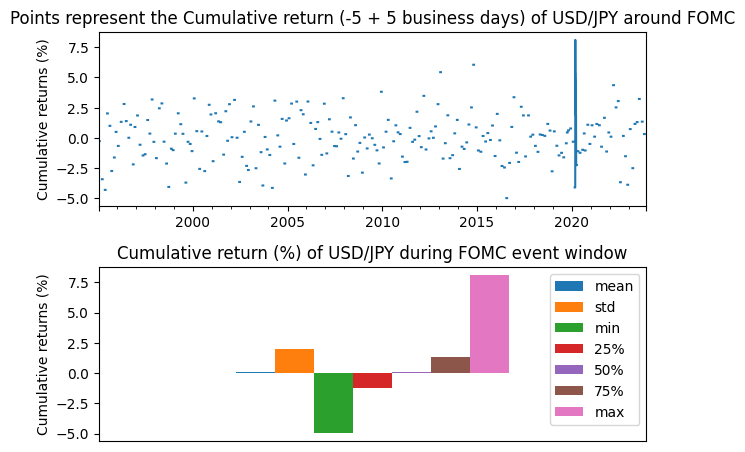

In [10]:
fig,axes = plt.subplots(nrows =2,ncols =1)
reindexed_Y_fomc.ffill(limit=10).plot(ax =axes[0],legend = False)
axes[0].set_title('Points represent the Cumulative return (-5 + 5 business days) of USD/JPY around FOMC')
axes[0].set_ylabel('Cumulative returns (%)')

Y_fomc.describe().T.drop('count',axis=1).reset_index(drop=True).plot(ax = axes[1],kind = 'bar')
axes[1].set_title('Cumulative return (%) of USD/JPY during FOMC event window')
fig.tight_layout()
axes[1].set_ylabel('Cumulative returns (%)')
axes[1].set_xticks([])

fig.savefig('plots/USD_JPY_spot_rate_during_fomc_2.png')

## comparing returns during FOMC period to returns during any other 10 days period

In [11]:
normal_returns = Y.dropna().pct_change().rolling(11).sum().dropna().sample(Y_fomc.shape[0]) *100
normal_returns.columns = ['Normal Returns']
fomc_returns = Y_fomc.copy().rename(columns ={'Y':'FOMC Returns'})

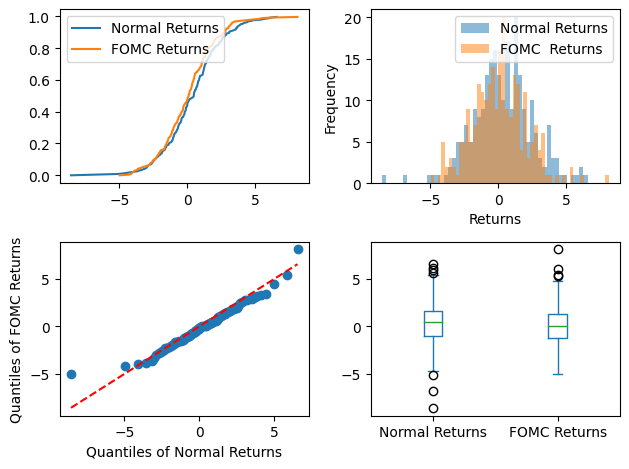

In [12]:
import numpy as np
import scipy.stats as stats

fig,axes = plt.subplots(nrows=2,ncols = 2)
# Calculating the CDF for both dataframes
normal_sorted = np.sort(normal_returns.iloc[:, 0])
fomc_sorted = np.sort(fomc_returns.iloc[:, 0])
normal_cdf = np.arange(len(normal_sorted)) / len(normal_sorted)
fomc_cdf = np.arange(len(fomc_sorted)) / len(fomc_sorted)
axes[0,0].plot(normal_sorted, normal_cdf, label='Normal Returns')
axes[0,0].plot(fomc_sorted, fomc_cdf, label='FOMC Returns')
axes[0, 0].legend()



axes[0,1].hist(normal_returns, bins=50, alpha=0.5, label = 'Normal Returns')
axes[0,1].hist(fomc_returns, bins=50, alpha=0.5, label = 'FOMC  Returns')
axes[0,1].set_xlabel('Returns')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()



# Calculate quantiles
normal_quantiles = np.percentile(normal_returns.iloc[:, 0], np.arange(0, 101))
fomc_quantiles = np.percentile(fomc_returns.iloc[:, 0], np.arange(0, 101))

# Plotting the Q-Q plot on the specified axes
axes[1, 0].plot(normal_quantiles, fomc_quantiles, marker='o', linestyle='')
axes[1, 0].plot(normal_quantiles, normal_quantiles, 'r--')  # Line for reference
axes[1, 0].set_xlabel('Quantiles of Normal Returns')
axes[1, 0].set_ylabel('Quantiles of FOMC Returns')

combined_data = pd.concat([normal_returns, fomc_returns])
combined_data.plot(kind = 'box', ax = axes[1,1]) 
fig.tight_layout()
fig.savefig('plots/USD_JPY_spot_rate_fomc_vs_normal.png')

## Simple OLS as a benchmark

In [27]:
path_target_period = os.path.join("results","JPY","all")
X_train = import_data(path_target_period,"X_train")
X_val = import_data(path_target_period,"X_val")
X_test = import_data(path_target_period,"X_test")
Y_train = import_data(path_target_period,"Y_train")
Y_val = import_data(path_target_period,"Y_val")
Y_test = import_data(path_target_period,"Y_test")
Y_raw  = import_data(path_target_period,"returns")
Y_test

Y
datetime            
2015-01-20 -1.035864
2015-03-10 -1.144233
2015-04-21  0.159543
2015-06-09 -0.295465
2015-07-21  0.401382
...              ...
2023-06-06  1.307989
2023-07-18  3.223852
2023-09-12  1.345410
2023-10-24  0.322313
2023-12-05 -2.228629

[78 rows x 1 columns]

In [29]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train) 
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())

coefs = pd.DataFrame({
    'coef': model.params,
    'pvalue': model.pvalues
})


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     1.410
Date:                Thu, 01 Feb 2024   Prob (F-statistic):             0.0656
Time:                        12:26:02   Log-Likelihood:                -257.18
No. Observations:                 163   AIC:                             696.4
Df Residuals:                      72   BIC:                             977.9
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.8202      2.319     

In [30]:
# alternatively
for table in model.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        Y         & \textbf{  R-squared:         } &    0.638  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    0.185  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    1.410  \\
\textbf{Date:}             & Thu, 01 Feb 2024 & \textbf{  Prob (F-statistic):} &  0.0656   \\
\textbf{Time:}             &     12:26:12     & \textbf{  Log-Likelihood:    } &  -257.18  \\
\textbf{No. Observations:} &         163      & \textbf{  AIC:               } &    696.4  \\
\textbf{Df Residuals:}     &          72      & \textbf{  BIC:               } &    977.9  \\
\textbf{Df Model:}         &          90      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabular}{lccc

                     coef    pvalue
CUSR0000SAD      0.540414  0.010939
FEDFUNDS        -0.821631  0.029555
NDMANEMP         0.752974  0.032481
DDURRG3M086SBEA -0.662589  0.049924
DMANEMP          0.972979  0.051939
AWOTMAN         -0.456422  0.064378
MANEMP          -0.672633  0.071661
USGOOD          -0.922471  0.074642
HOUSTNE          0.401811  0.079398
HOUSTS           0.807605  0.086387


C:\Users\marti\AppData\Local\Temp\ipykernel_20152\2338690554.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top_10_coefs.index, rotation=90)
C:\Users\marti\AppData\Local\Temp\ipykernel_20152\2338690554.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(top_10_coefs.index, rotation=90)


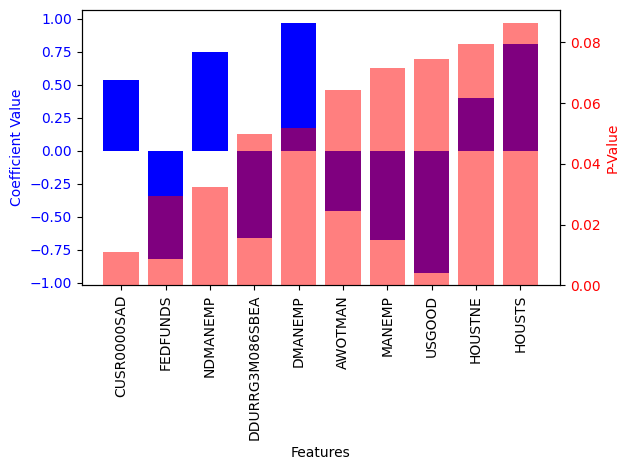

In [15]:

top_10_coefs = coefs.sort_values(by='pvalue').head(10)
print(top_10_coefs)

# Creating the histogram plot
fig, ax1 = plt.subplots()

# Left axis for coefficients
ax1.bar(top_10_coefs.index, top_10_coefs['coef'], color='b', label='Coefficient')
ax1.set_xlabel('Features')
ax1.set_ylabel('Coefficient Value', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(top_10_coefs.index, rotation=90)
# Right axis for p-values
ax2 = ax1.twinx()
ax2.bar(top_10_coefs.index, top_10_coefs['pvalue'], color='r', alpha=0.5, label='P-Value')
ax2.set_ylabel('P-Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xticklabels(top_10_coefs.index, rotation=90)
fig.tight_layout()
fig.savefig('plots/USD_JPY_coefs_ols.png')

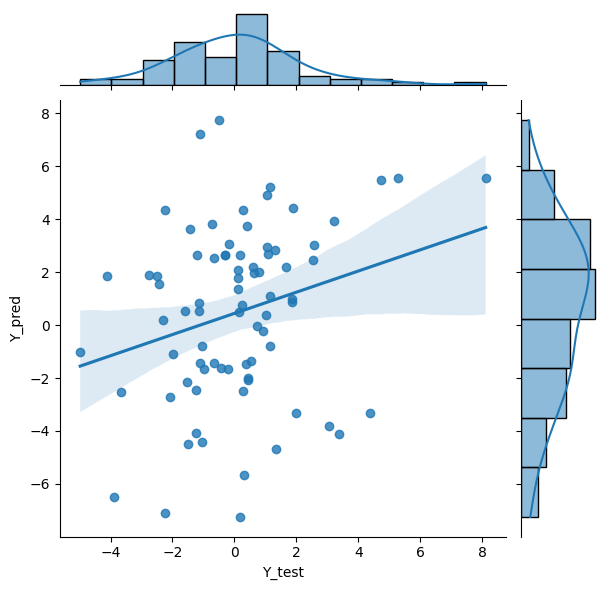

In [16]:
import seaborn as sns
import statsmodels.api as sm

Y_pred = model.predict(sm.add_constant(X_test))
jointplot = sns.jointplot(x=Y_test.iloc[:, 0], y=Y_pred, kind="reg")
jointplot.set_axis_labels('Y_test', 'Y_pred')
jointplot.savefig("plots/ols_benchmark_jointplot_output.png")

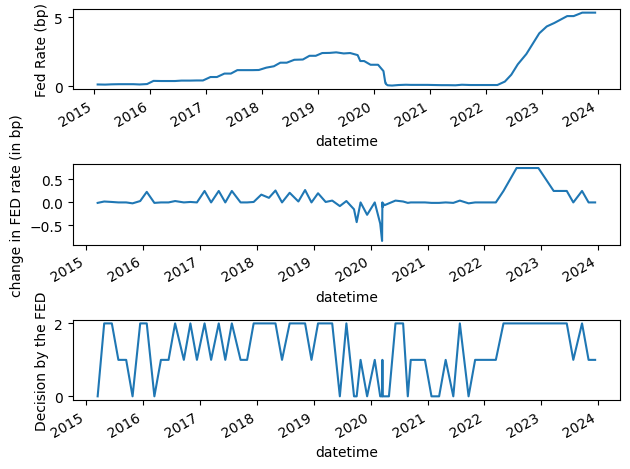

In [17]:
### merge dfed rate 
indicator = aggregate_data("Indicator/US").loc['2015':]
rates_change = indicator[['DFF']].shift(-1).join(fomc_calendar[['unscheduled']])

rates_change.dropna(inplace=True)
rates_change['change in fed rate'] = rates_change['DFF'].diff()
rates_change['outcome'] = np.sign(rates_change['change in fed rate']) +1

fig,axes = plt.subplots(nrows=3,ncols = 1)
rates_change['DFF'].plot(ax = axes[0])
axes[0].set_ylabel('Fed Rate (bp)')

rates_change['change in fed rate'].plot(ax = axes[1])
axes[1].set_ylabel('change in FED rate (in bp)')

rates_change['outcome'].plot(ax = axes[2])
axes[2].set_ylabel("Decision by the FED")
fig.tight_layout()
fig.savefig('plots/FOMC_change_plot.png')
fomc_calendar = pd.read_parquet('data/FOMC/fomc_calendar.parquet').set_index('datetime')
fomc_dates = rates_change['outcome'].dropna().to_dict()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 78/78 [00:00<00:00, 440.72it/s]


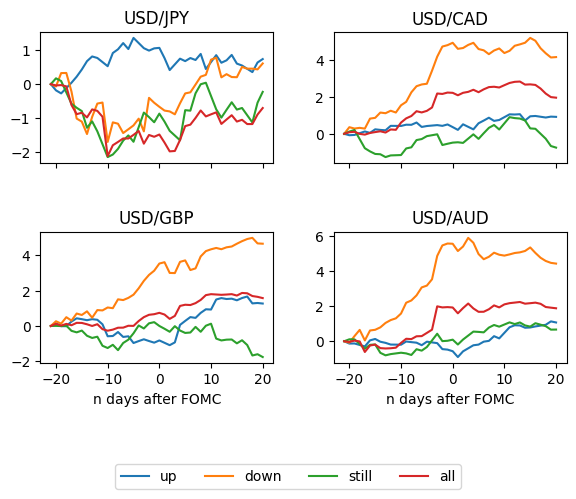

In [26]:
%load_ext autoreload
%autoreload 2
from utils import * 

currencies = aggregate_data("Currencies")
list_currencies = ['JPY','CAD','GBP','AUD']
fig,axes = plt.subplots(nrows = 2, ncols = 2,sharex=True)
for i, ax in enumerate(axes.flatten()):
    curr = list_currencies[i]
    data = currencies[[curr]]
    data.columns = ['close']
    data = features_for_model(data).fillna(0)
    profile = get_profile(data[['norm_daily_returns']],fomc_dates,offset=20) 
    (profile).cumsum().plot(ax = ax,legend=False)
    ax.set_title('USD/'+curr )
    ax.set_xlabel('n days after FOMC')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=4, bbox_to_anchor=(0.5, -0.1))
fig.tight_layout(pad=3.0)
fig.savefig('plots/profile_fomc_event.png', bbox_inches='tight')

## Visualizing Model results

In [32]:
%load_ext autoreload
%autoreload 2
from utils import * 
metrics = get_metrics("results_tuned","all","JPY")
coefs = get_coefs("results_tuned","all","JPY")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


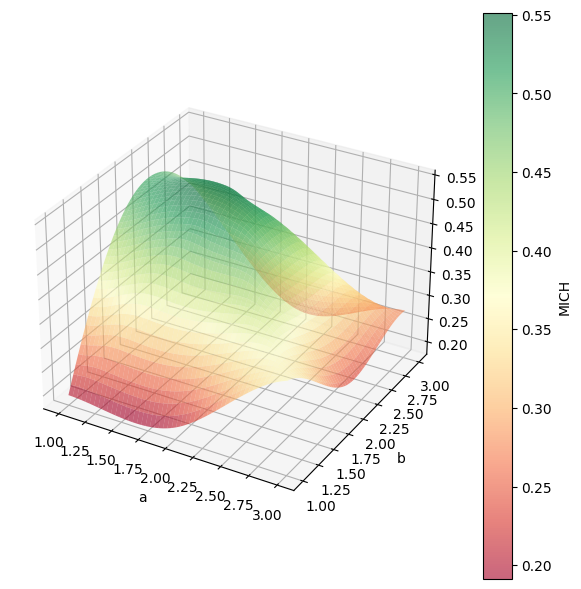

In [42]:
plot_surface_coef(coefs,param1 = "a", param2 = 'b',coef_name = "MICH")

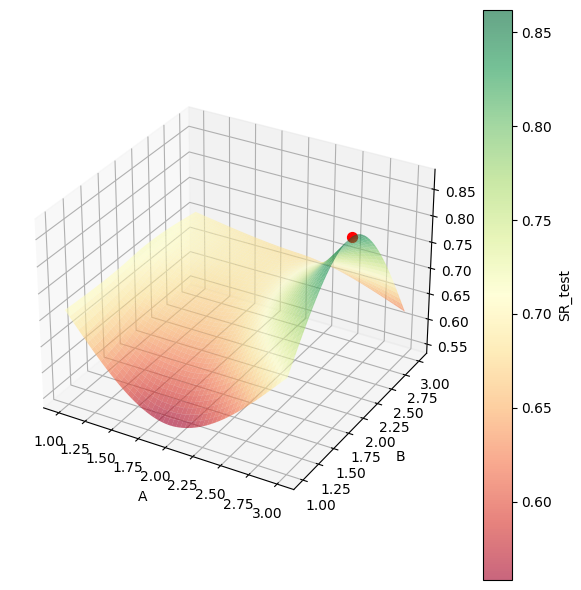

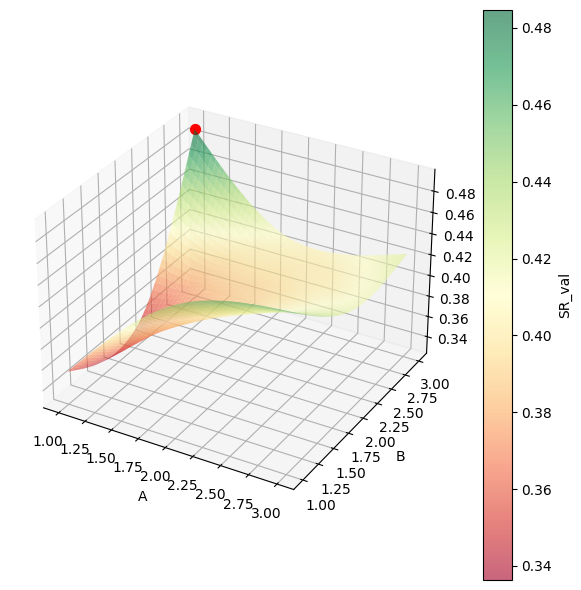

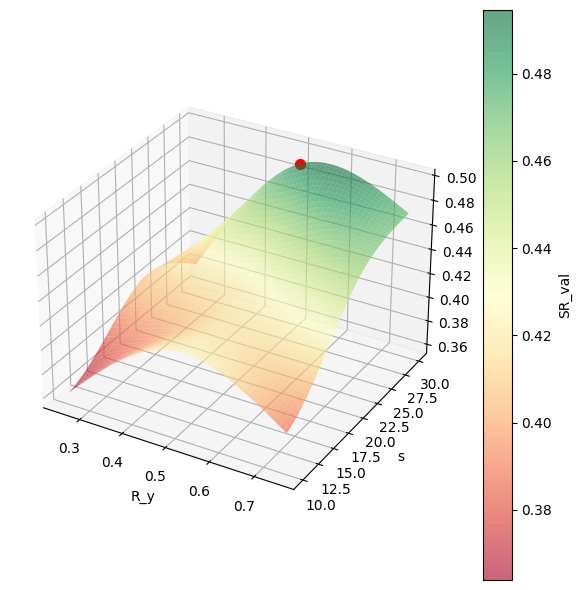

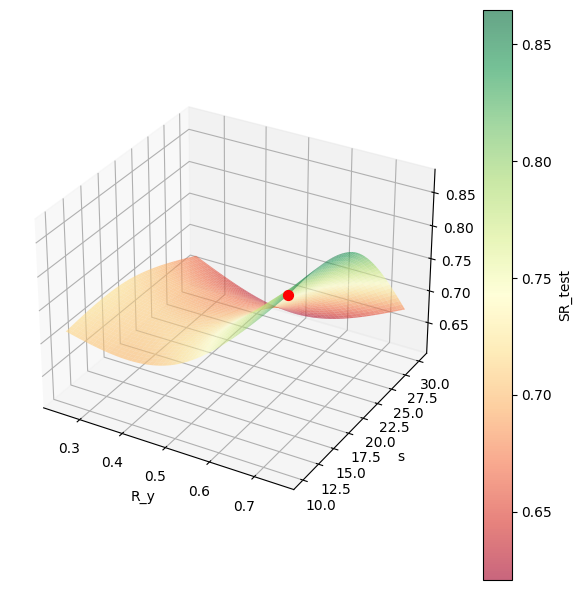

In [161]:


plot_surface_metric(metrics,"A","B","SR_test")
plot_surface_metric(metrics,"A","B","SR_val")

plot_surface_metric(metrics,"R_y","s","SR_val")
plot_surface_metric(metrics,"R_y","s","SR_test")



In [164]:
metrics = get_metrics("results_tuned","all","JPY")
coefs = get_coefs("results_tuned","all","JPY")
path_target_period = os.path.join("results_tuned","JPY","all")
X_train = import_data(path_target_period,"X_train")
X_val = import_data(path_target_period,"X_val")
X_test = import_data(path_target_period,"X_test")
Y_train = import_data(path_target_period,"Y_train")
Y_val = import_data(path_target_period,"Y_val")
Y_test = import_data(path_target_period,"Y_test")
Y_raw  = import_data(path_target_period,"returns")

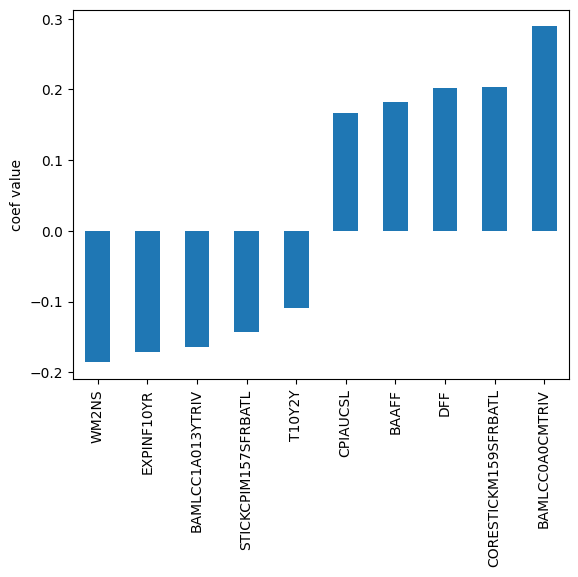

In [170]:
results= metrics.copy()
results = results.sort_values(by= "SR_train",ascending= False)
a,b,A,B,s,R_y = (*get_best_parameters(results),)
betas = recover_model(coefs,a,b,A,B,s,R_y)
predictions= (get_prediction(X_test,betas,X_test.index))
fig,axes = plt.subplots(nrows=1,ncols =1)
bottom_betas = betas.sort_values(by = 'coef',ascending=True).head(5) 
top_betas= betas.sort_values(by = 'coef',ascending=False).head(5)
concatenated_betas = pd.concat([top_betas, bottom_betas]).sort_values(by='coef')
concatenated_betas.sort_values(by = 'coef').plot(kind = 'bar', ax = axes,legend=False)
axes.set_ylabel('coef value')

fig.savefig('plots/bayes_coefs_jpy.png')

In [171]:
fed_meetings = get_fomc_calendar()
Y = create_Y(Y_raw,fed_meetings,"all")
indicator = zscore(indicator,252).dropna()
data = Y.join(indicator).dropna()

In [172]:
_,X,Y= load_data(data,"Y")
X_train, X_val, X_test = split_data(X)
Y_train, Y_val, Y_test = split_data(Y)
X_train

Empty DataFrame
Columns: [T10Y2Y, T5YIE, BAA10Y, T10YFF, TB3SMFFM, BAAFF, MORTGAGE30US, DFF, RRPONTSYD, UNRATE, CPIAUCSL, WM2NS, WALCL, T10Y3M, BAMLH0A0HYM2, DGS10, MSPUS, T10YIE, FPCPITOTLZGUSA, CORESTICKM159SFRBATL, WM1NS, GFDEGDQ188S, SP500, VIXCLS, VXVCLS, VXNCLS, BAMLHYH0A0HYM2TRIV, BAMLCC0A0CMTRIV, BAMLHE00EHYITRIV, BAMLHYH0A3CMTRIV, BAMLCC1A013YTRIV, BAMLCC0A1AAATRIV, MEDCPIM158SFRBCLE, MICH, EXPINF10YR, DFII10, DPCCRV1Q225SBEA, PCETRIM12M159SFRBDAL, EXPINF2YR, EXPINF1YR, STICKCPIM157SFRBATL, EXPINF30YR]
Index: []

[0 rows x 42 columns]

In [202]:
coefs_to_plot= ["DFF","MICH","UNRATE","STICKCPIM157SFRBATL"]
coefs_comparison = pd.DataFrame(index = CURRENCIES, columns = ["DFF","MICH","UNRATE","STICKCPIM157SFRBATL"])
for currency in CURRENCIES:
    metrics = get_metrics("results_tuned","all",currency)
    coefs = get_coefs("results_tuned","all",currency)
    results = metrics.sort_values(by= "R2_train",ascending= False)
    a,b,A,B,s,R_y = (*get_best_parameters(metrics),)
    s = 30
    R_y = 0.75
    betas = coefs.query('a == @a and b == @b and A == @A and B == @B and s == @s and R_y == @R_y').drop(["a","b","A","B","s","R_y"],axis=1).T
    betas = recover_model(coefs,a,b,A,B,s,R_y)
    for ts in coefs_to_plot:
        coefs_comparison.loc[currency,ts] =  betas.loc[ts,'coef']


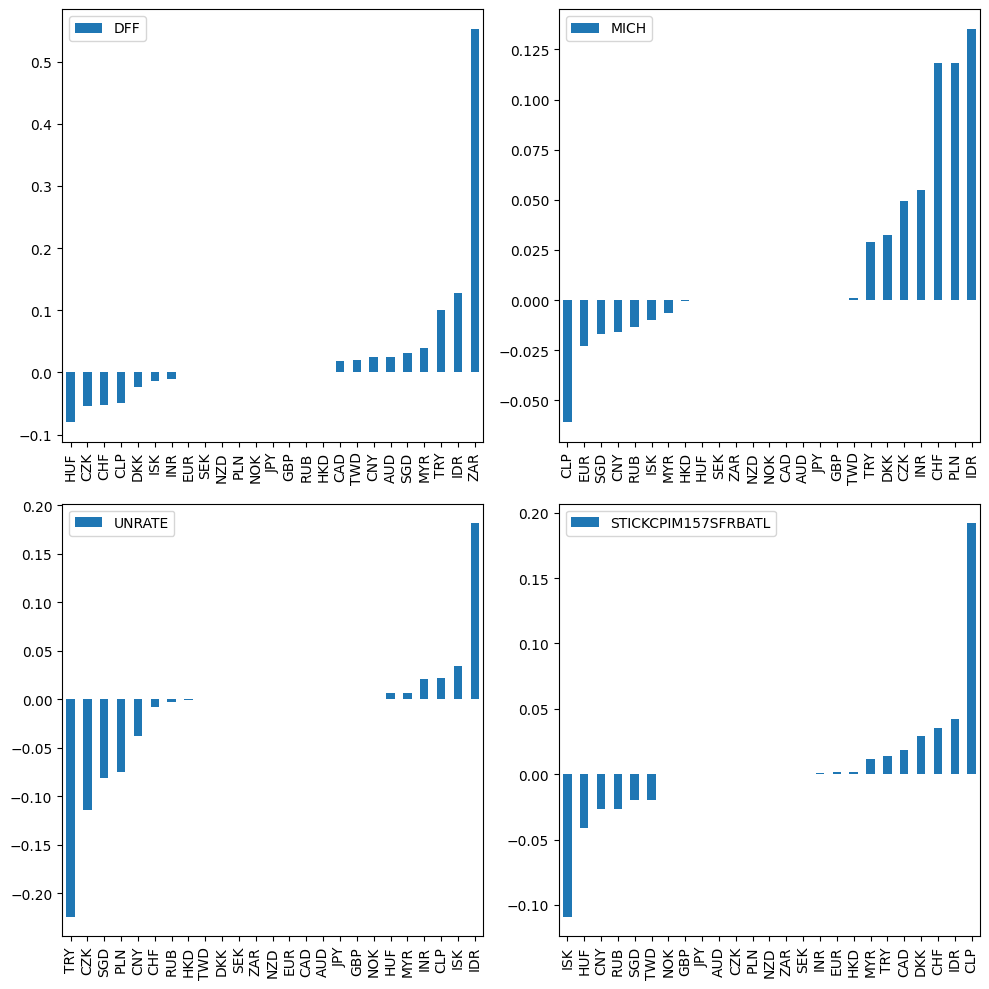

In [203]:

fig,axes = plt.subplots(nrows = 2,ncols = 2,sharex=False, figsize = (10,10))
for i,ax in enumerate(axes.flatten()):
    coefs_comparison.iloc[:,i].sort_values().plot(kind = 'bar',ax = ax, label = coefs_to_plot[i])
    ax.legend()
fig.tight_layout()
fig.savefig('plots/cmpr_coefs_fomc.png')

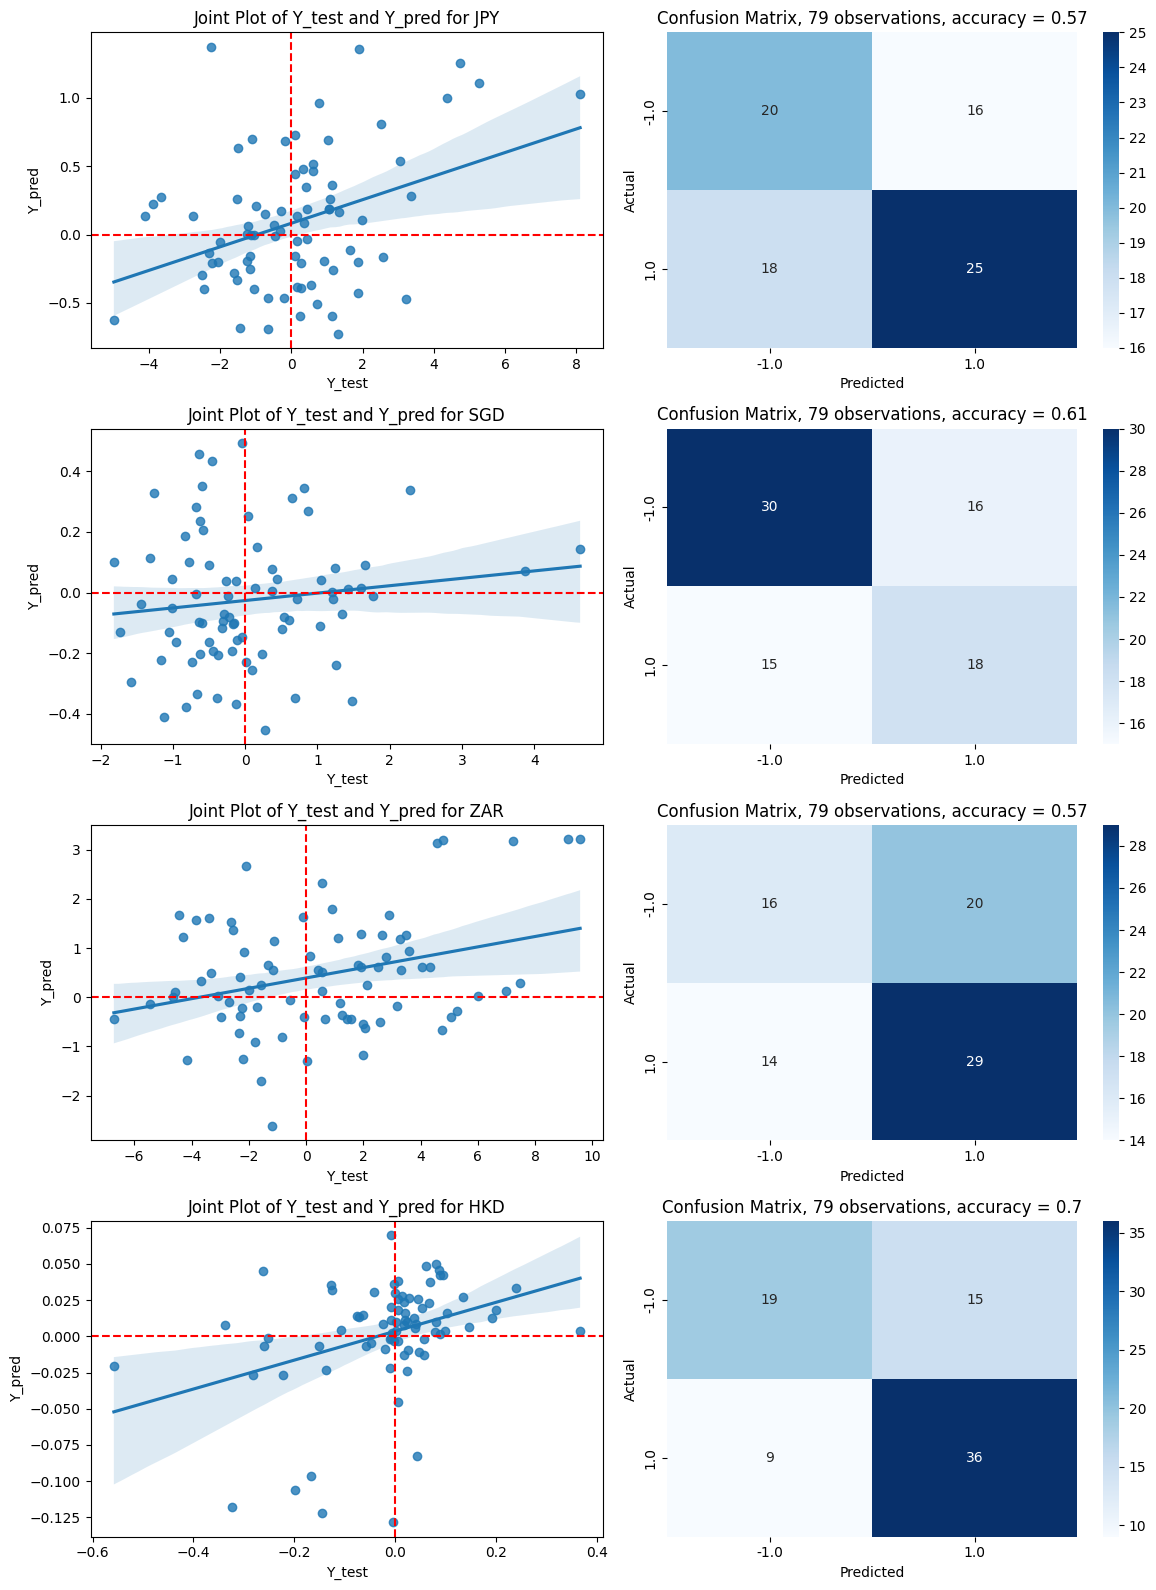

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [277]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming functions import_data, get_metrics, get_coefs, get_best_parameters, recover_model, and get_prediction are defined

currency_to_plot = ["JPY", "SGD", "ZAR", "HKD"]

# Correctly unpacking the tuple returned by plt.subplots
fig, axes = plt.subplots(nrows=len(currency_to_plot), ncols=2, figsize=(12, 4 * len(currency_to_plot)))

for i, currency in enumerate(currency_to_plot):
    path_target_period = os.path.join("results_tuned", currency, "all")
    # Assuming the import_data function and other functions work as intended
    X_train = import_data(path_target_period, "X_train")
    X_val = import_data(path_target_period, "X_val")
    X_test = import_data(path_target_period, "X_test")
    Y_train = import_data(path_target_period, "Y_train")
    Y_val = import_data(path_target_period, "Y_val")
    Y_test = import_data(path_target_period, "Y_test")
    Y_raw = import_data(path_target_period, "returns")

    metrics = get_metrics("results_tuned", "all", currency)
    coefs = get_coefs("results_tuned", "all", currency)
    metrics = metrics.sort_values(by="R2_val", ascending=False)
    a, b, A, B, s, R_y = (*get_best_parameters(metrics),)
    betas = recover_model(coefs, a, b, A, B, s, R_y)
    predictions = get_prediction(X_test, betas, X_test.index)
    cmpr = pd.DataFrame({'Y': Y_test.iloc[:, 0], 'predictions': predictions.iloc[:, 0]})
    sns.regplot(x='Y', y='predictions', data=cmpr, ax=axes[i, 0])
    axes[i, 0].set_xlabel('Y_test')
    axes[i, 0].set_ylabel('Y_pred')
    axes[i, 0].axvline(0, color='r', ls='--')
    axes[i, 0].axhline(0, color='r', ls='--')
    axes[i, 0].set_title(f'Joint Plot of Y_test and Y_pred for {currency}')


    cmpr = np.sign(cmpr)
    accuracy = accuracy_score(cmpr['Y'], cmpr['predictions'])
    cm = confusion_matrix(cmpr['Y'], cmpr['predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["-1.0", "1.0"], yticklabels=["-1.0", "1.0"],ax = axes[i,1])
    axes[i,1].set_ylabel('Actual')
    axes[i,1].set_xlabel('Predicted')
    axes[i,1].set_title('Confusion Matrix, {} observations, accuracy = {}'.format(cmpr.shape[0], np.round(accuracy,2)))

fig.tight_layout()
fig.savefig('plots/regplot_and_confusion_matrix.png')

### Aggregating model results to create a global long short portfolio

In [43]:
%load_ext autoreload
%autoreload 2
from utils import * 
from settings.default import CURRENCIES
from data_handling import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
pnls = {}
signals ={}
returns = {}
table_results = pd.DataFrame(index =CURRENCIES, columns = ['beta','T-stat','R2','p-value','bias (bp)', '% winning trade','Sharpe ratio']) 

for curr in tqdm(CURRENCIES):
    pnl_all,signal_all,ret  = get_best_pnl(curr,"all",criterion = "SR_val")
    signals[curr] = signal_all 
    pnls[curr] = pnl_all
    returns[curr] = ret
    cmpr = ret.pct_change().join(signal_all/100).dropna()
    beta, t_stat, p_value, r_squared = simple_ols_regression(cmpr)
    table_results.loc[curr,'beta'] = beta
    table_results.loc[curr,'T-stat'] = t_stat
    table_results.loc[curr,'R2'] = r_squared
    table_results.loc[curr,'p-value'] = p_value
    table_results.loc[curr,'bias (bp)'] = pnl_all.mean() *1e4
    table_results.loc[curr,'Sharpe ratio'] = sharpe_ratio(pnl_all)
    table_results.loc[curr,'% winning trade'] =((np.sign(pnl_all.replace(0,np.nan).dropna())+1).sum()/2)/ pnl_all.replace(0,np.nan).dropna().shape[0]

pnl_combined = pd.concat(pnls,axis=1)
alpha = pd.concat(signals,axis=1).droplevel(axis=1,level=1)

100%|██████████| 25/25 [00:03<00:00,  8.18it/s]


In [74]:
table_results

beta    T-stat        R2   p-value bias (bp) % winning trade   
EUR  2.598954  1.153745  0.001617   0.24894  0.009373         0.51411  \
RUB  0.127992  0.287055    0.0001  0.774143  1.088174        0.517705   
GBP  0.122201  1.459613  0.002585  0.144778  0.291747        0.510429   
CNY  0.343072  0.773892  0.000728  0.439217   0.00964        0.509804   
JPY  0.217785  2.473166  0.007386  0.013593  0.432168        0.529197   
SGD  0.058536  1.489187  0.002691  0.136822  0.168231        0.527027   
INR  1.787566  1.336242  0.002167   0.18184  0.005143        0.517748   
CHF  0.696985  2.528048  0.007715  0.011656  0.107118        0.554321   
AUD  0.409369  1.742541   0.00368  0.081788  0.185652        0.522755   
CAD  0.041475  0.722026  0.000634  0.470484  0.270281        0.506716   
HKD  0.112886  2.210252  0.005908  0.027362  0.003616        0.560914   
MYR  0.093492  1.227198  0.001829    0.2201  0.102566        0.517241   
NOK  0.212774  0.851283  0.000881   0.39486  0.270309        0.521845   
NZD  0.085509  2.518686  0.007658  0.011968  1.701961        0.535366   
ZAR  0.074137  2.091165  0.005292   0.03682  2.521015        0.523058   
SEK  0.237617  1.489072   0.00269  0.136852  0.275674        0.523058   
DKK  0.224352  1.758495  0.003748  0.079035  0.185655        0.513973   
TWD  1.114119  2.571363   0.00798  0.010305  0.022935        0.528325   
CLP  0.095405  1.682413  0.003432  0.092869  0.769792        0.508537   
CZK  0.033845  1.651934  0.003309   0.09893  1.377137        0.518834   
HUF  0.076631  2.594952  0.008125  0.009629  2.604929        0.516403   
IDR  0.037922  1.509334  0.002764  0.131598  0.599182        0.513158   
ISK  0.070876  2.017531  0.004927  0.043965   1.20703        0.513415   
PLN  0.189026  1.097884  0.001464  0.272576  0.164516        0.503659   
TRY  0.553532  0.913908  0.001015  0.361033   0.23953        0.540049   

    Sharpe ratio  
EUR     0.441668  
RUB     0.297019  
GBP     0.552836  
CNY     0.551941  
JPY     0.864509  
SGD     0.435766  
INR     0.464465  
CHF     0.741863  
AUD     0.638898  
CAD     0.454386  
HKD     0.963281  
MYR     0.423504  
NOK     0.652189  
NZD     0.937387  
ZAR     0.609697  
SEK     0.753291  
DKK     0.639984  
TWD     0.725935  
CLP     0.536595  
CZK     0.469047  
HUF     0.772851  
IDR     0.625984  
ISK     0.546203  
PLN     0.365802  
TRY     0.911853

In [76]:
print(table_results.to_latex())

\begin{tabular}{llllllll}
\toprule
 & beta & T-stat & R2 & p-value & bias (bp) & % winning trade & Sharpe ratio \\
\midrule
EUR & 2.598954 & 1.153745 & 0.001617 & 0.248940 & 0.009373 & 0.514110 & 0.441668 \\
RUB & 0.127992 & 0.287055 & 0.000100 & 0.774143 & 1.088174 & 0.517705 & 0.297019 \\
GBP & 0.122201 & 1.459613 & 0.002585 & 0.144778 & 0.291747 & 0.510429 & 0.552836 \\
CNY & 0.343072 & 0.773892 & 0.000728 & 0.439217 & 0.009640 & 0.509804 & 0.551941 \\
JPY & 0.217785 & 2.473166 & 0.007386 & 0.013593 & 0.432168 & 0.529197 & 0.864509 \\
SGD & 0.058536 & 1.489187 & 0.002691 & 0.136822 & 0.168231 & 0.527027 & 0.435766 \\
INR & 1.787566 & 1.336242 & 0.002167 & 0.181840 & 0.005143 & 0.517748 & 0.464465 \\
CHF & 0.696985 & 2.528048 & 0.007715 & 0.011656 & 0.107118 & 0.554321 & 0.741863 \\
AUD & 0.409369 & 1.742541 & 0.003680 & 0.081788 & 0.185652 & 0.522755 & 0.638898 \\
CAD & 0.041475 & 0.722026 & 0.000634 & 0.470484 & 0.270281 & 0.506716 & 0.454386 \\
HKD & 0.112886 & 2.210252 & 0.005908

sharpe      2.6
bias        2.5
turnover    6.4
dtype: float64

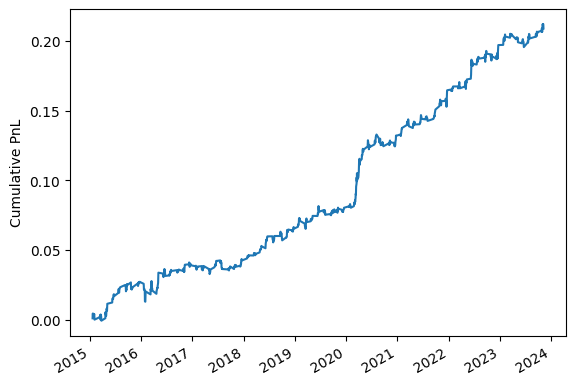

In [80]:
from scipy.stats import norm
signals_aggregated = pd.concat(signals,axis=1).droplevel(axis=1,level=1)
signals_aggregated = signals_aggregated.rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signals_aggregated = signals_aggregated.sub(signals_aggregated.mean(1),0)
alpha = signals_aggregated.div(signals_aggregated.abs().sum(1),0)
R = pd.concat(returns,axis=1).droplevel(axis=1,level=1).pct_change()
pnls = (alpha.shift() * R).dropna(axis=0,how = 'all')
pnl = pnls.sum(1)
turnover = alpha.fillna(0).diff().abs().sum(1).mean() *100
pnl.cumsum().plot()
plt.ylabel('Cumulative PnL')
plt.savefig('plots/cumulative_pnl.png')
pd.Series({"sharpe":sharpe_ratio(pnl),'bias':pnl.mean()*1e4, 'turnover':turnover}).round(1)

In [79]:
alpha.fillna(0).diff().abs().sum(1).mean() *100

6.3858990918335135

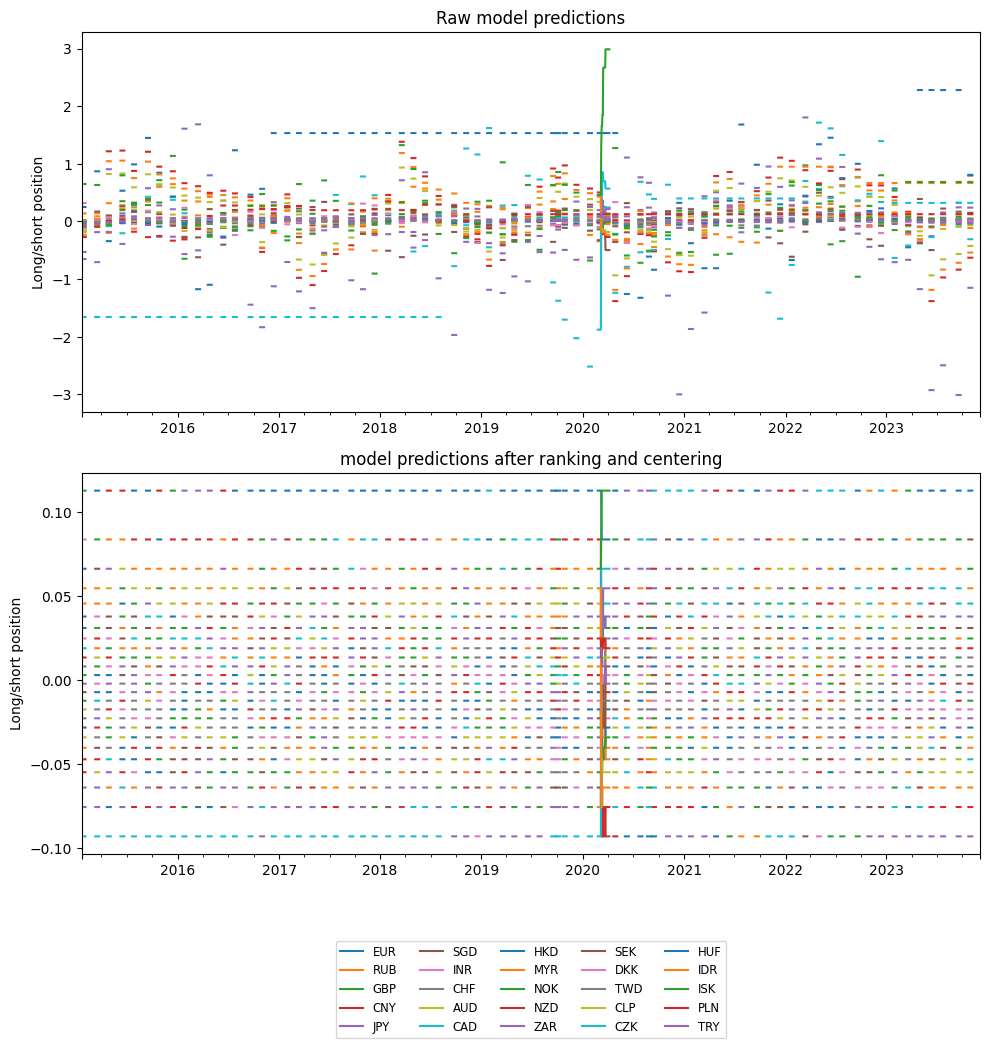

In [73]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize = (10,10))
pd.concat(signals,axis=1).droplevel(axis=1,level=1).plot(ax = axes[0],legend=False)
axes[0].set_title('Raw model predictions')
axes[0].set_ylabel('Long/short position')


alpha.plot(ax = axes[1])
axes[1].set_title('model predictions after ranking and centering')
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),ncol=5,fontsize='small')
axes[1].set_ylabel('Long/short position')
fig.subplots_adjust(bottom=0.3)
fig.tight_layout()
fig.savefig('plots/model_predictions_positions.png')

In [81]:
import shutil
shutil.rmtree('results')

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=2)
alpha.plot(ax = ax)
import matplotlib.pyplot as plt
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),ncol=5,fontsize='small')
ax.set_ylabel('Long/short position')
fig.subplots_adjust(bottom=0.3)
fig.tight_layout()

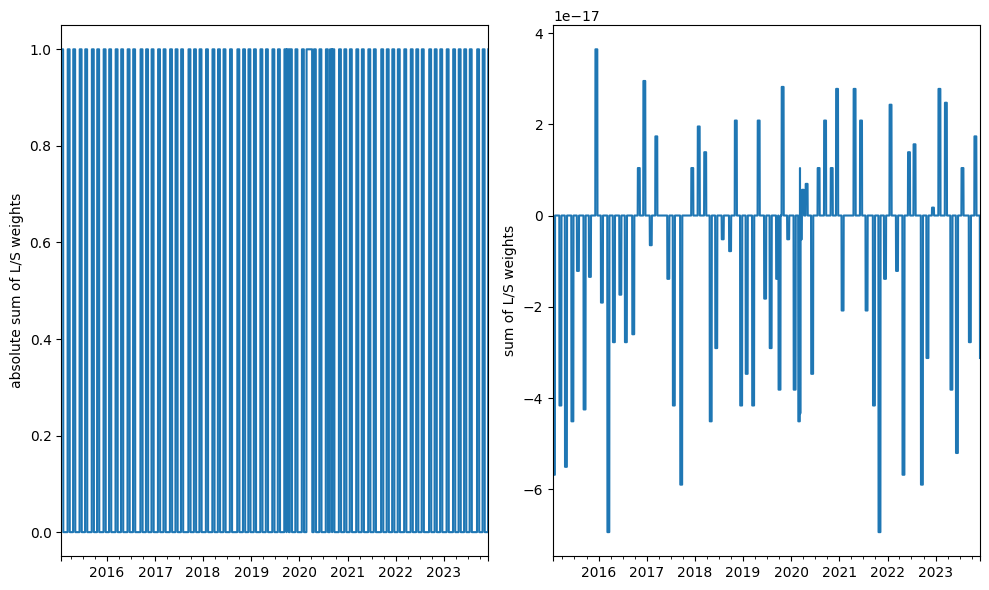

In [527]:
fig,axes = plt.subplots(nrows=1,ncols =2,figsize = (10,6))
alpha.abs().sum(1).plot(ax = axes[0])
axes[0].set_ylabel('absolute sum of L/S weights')

alpha.sum(1).plot(ax = axes[1])
axes[1].set_ylabel('sum of L/S weights')
fig.tight_layout()
fig.savefig('plots/sum_weights.png')

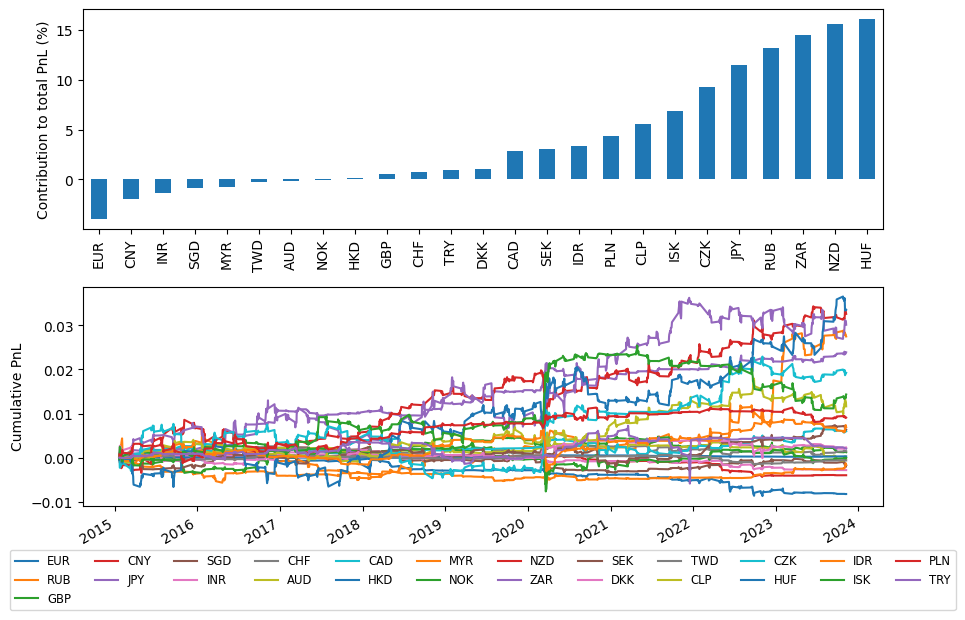

In [528]:
fig,axes = plt.subplots(ncols=1,nrows =2,figsize = (10,6))
(100*(pnls.cumsum().iloc[-1] / pnl.cumsum().iloc[-1]).sort_values()).plot(ax = axes[0],kind ='bar')
axes[0].set_ylabel('Contribution to total PnL (%)')
pnls.cumsum().plot(ax = axes[1])
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),ncol=12,fontsize='small')
axes[1].set_ylabel('Cumulative PnL')
fig.subplots_adjust(bottom=0.3)
fig.tight_layout()
fig.savefig('plots/contribution_pnl.png')


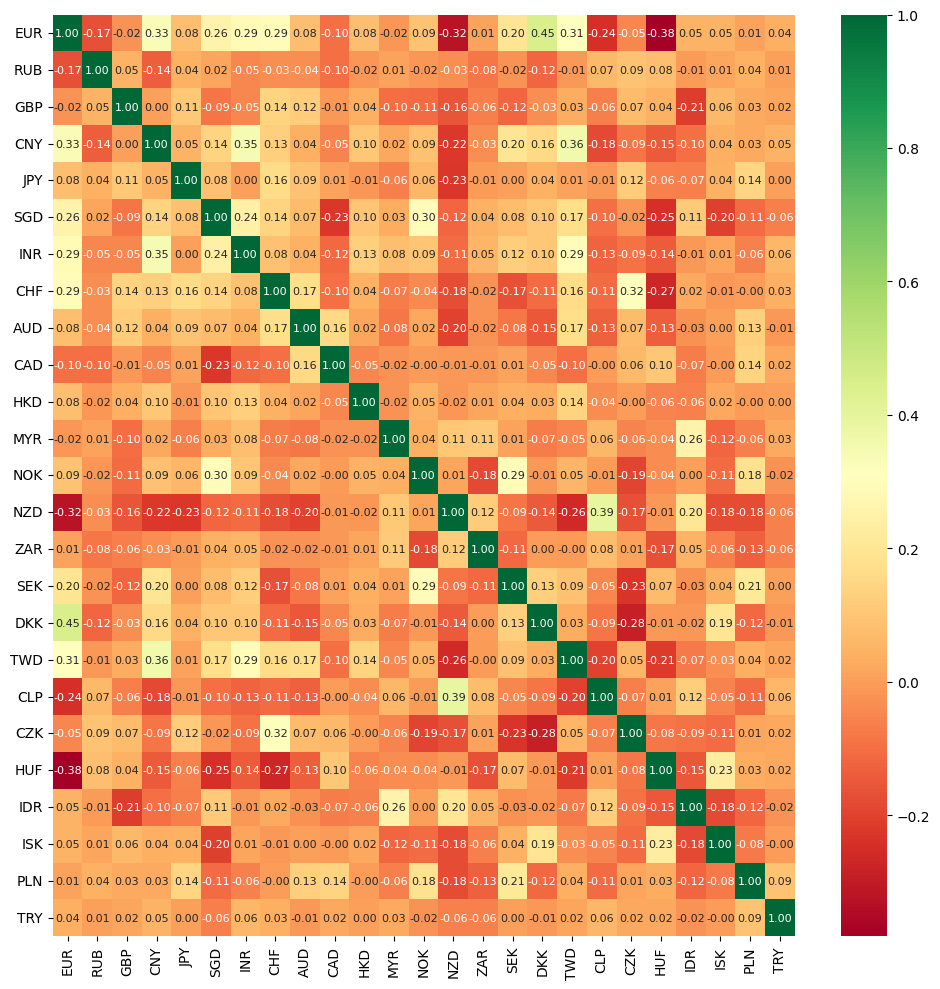

In [534]:
daily_cov_matrix = pnls.corr()
annual_cov_matrix = daily_cov_matrix
fig,axes = plt.subplots(nrows=1,ncols=1, figsize = (10,10))
sns.heatmap(annual_cov_matrix, annot=True, fmt='.2f', cmap='RdYlGn',ax = axes,annot_kws={"size": 8})
fig.tight_layout()
fig.savefig('plots/pnl_corr_matrix.png')

In [535]:
import os
import glob

def clean_currency_directories(currencies, results_dir):
    for currency in currencies:
        # Construct the path to the currency's 'all' directory
        currency_dir_path = os.path.join(results_dir, currency, 'all')
        
        # Check if the path exists and is a directory
        if os.path.exists(currency_dir_path) and os.path.isdir(currency_dir_path):
            # List all files that are not CSV files
            non_csv_files = glob.glob(os.path.join(currency_dir_path, '*'))
            non_csv_files = [f for f in non_csv_files if not f.lower().endswith('.csv')]
            
            # Delete all files that are not CSV files
            for file_path in non_csv_files:
                try:
                    os.remove(file_path)
                    print(f"Deleted file: {file_path}")
                except Exception as e:
                    print(f"Error deleting file {file_path}: {e}")
        else:
            print(f"The directory {currency_dir_path} does not exist.")



In [540]:
import os
import glob

def clean_currency_directories(currencies, results_dir):
    for currency in currencies:
        # Construct the path to the currency's 'all' directory
        currency_dir_path = os.path.join(results_dir, currency, 'all')
        
        # Check if the path exists and is a directory
        if os.path.exists(currency_dir_path) and os.path.isdir(currency_dir_path):
            # List all files that are not CSV files
            non_csv_files = glob.glob(os.path.join(currency_dir_path, '*'))
            non_csv_files = [f for f in non_csv_files if not f.lower().endswith('.csv')]
            
            # Delete all files that are not CSV files
            for file_path in non_csv_files:
                try:
                    shutil.rmtree(file_path)
                    print(f"Deleted file: {file_path}")
                except Exception as e:
                    print(f"Error deleting file {file_path}: {e}")
        else:
            print(f"The directory {currency_dir_path} does not exist.")


clean_currency_directories(CURRENCIES, RESULTS_DIR)


Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=20_R_y=0.75
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=10_R_y=0.25
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=10_R_y=0.5
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=10_R_y=0.75
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=20_R_y=0.25
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=20_R_y=0.5
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=30_R_y=0.25
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=30_R_y=0.5
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=1_s=30_R_y=0.75
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=2_s=10_R_y=0.25
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=2_s=10_R_y=0.5
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=2_s=10_R_y=0.75
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=2_s=20_R_y=0.25
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=2_s=20_R_y=0.5
Deleted file: results_tuned\EUR\all\a=1_b=1_A=1_B=2_s=20_R_y=0.75
Deleted file: r